In [28]:
# import libraries

import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils
from scipy.stats import entropy, pearsonr
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.metrics import mean_absolute_error
import random
import copy
import uncertainty_metrics.numpy as um
#import tensorflow_probability as tfp

sns.set_color_codes()
%matplotlib inline

sns.set(font="Calibri")
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,"xtick.labelsize":14,"ytick.labelsize":14,"legend.fontsize":14,"legend.title_fontsize":14})   

# Define some helper functions for packaging the dataframe

In [3]:
# function for packaging pickels into dataframes
def reshape_mc_predictions(X):
    # change the shape from N * M to M * N
    
    X = np.array(X)
    new_list = []
    for index in range(0, len(X[0])):
        new_row = X[:, index, None]
        new_list.append(new_row)
    
    #print("new len", len(new_list), len(new_list[0]))
    return new_list

def package_pickle(X, y, labels, run_name):
    
    #print(np.array(X).shape, np.array(y).shape, np.array(labels).shape)
    
    # get all the pickels into a dataframe for easier processing
    run_names = [run_name] * len(X)
    labels = [labels] * len(X)
    
    #print(len(X), len(y), len(labels), len(run_names))
    dataframe_dict = [] 
    
    for index in range(0, len(X)):
        dataframe_dict.append({'mc_predictions': X[index], 'y_true': y[index], 'labels': labels[index], 'run_name': run_name})
    
    df = pd.DataFrame(data=dataframe_dict)
    #print(df.head())
    return df

def package_pickles(pickle_paths):
    
    df = pd.DataFrame([], columns=["mc_predictions", "y_true", "labels", "run_name", "trip_method", "method"])
    
    for item in pickle_paths:
        #print(item)
        X_path = item["X_path"]
        y_val_path = item["y_val_path"]
        labels_path = item["labels_path"]
        run_name = item["run_name"]
        trip_method = item["trip_method"]
        method = item["method"]
        data_shift = item["data_shift"]
        #print(run_name)
        X = pickle.load(open(X_path, "rb"))
        y_val = pickle.load(open(y_val_path, "rb"))
        
        with open(labels_path) as f:
            labels = f.readlines()
            
        # you may also want to remove whitespace characters like `\n` at the end of each line
        labels = [x.strip() for x in labels]
        
        X = reshape_mc_predictions(X)
        df2 = package_pickle(X, y_val, labels, run_name)
        df2["trip_method"] = trip_method
        df2["method"] = method
        df2["data_shift"] = data_shift
        df = df.append(df2)

    return df

def generate_derived_properties(df):
    properties = []
    
    for index, row in df.iterrows():
        #print(index)
        y = row['y_true'] #np.expand_dims(y_true[patch_index], 0)
        # predict stochastic dropout model T times - number of prediction runs
        p_hat = []
        #print(len(y))
        #print(len(row['mc_predictions']), len(row['mc_predictions'][0]))
        #print(len(df.loc[index,'mc_predictions']), len(df.loc[index, 'mc_predictions'][0]))
        
        for t in range(len(row['mc_predictions'])):
            # print(model.predict(image))
            p_hat.append(row['mc_predictions'][t])
        p_hat = np.array(p_hat)
        #p_hat = p_hat[0]

        # p_hat = result
        # mean prediction
        prediction_dist = np.mean(p_hat, axis=0)[0]
        #print("dist", len(prediction_dist))
        variance = np.var(p_hat, axis=0)[0]
        std_dev = np.std(p_hat, axis=0)[0]
        # threshold mean prediction
        # prediction = np.where(prediction > 0.5, 1, 0)

        # estimate uncertainties (eq. 4 )
        # eq.4 in https://openreview.net/pdf?id=Sk_P2Q9sG
        # see https://github.com/ykwon0407/UQ_BNN/issues/1
        aleatoric = np.mean(p_hat * (1 - p_hat), axis=0)[0]
        epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
        
        predicted_index = np.argmax(prediction_dist)
        y_index = np.argmax(y)
        #print("index", predicted_index)
        prediction_score = prediction_dist[predicted_index]
        prediction_label = row['labels'][predicted_index]
        true_label = row['labels'][y_index]
        prediction_epistemic = variance[predicted_index]
        prediction_aleatoric = aleatoric[predicted_index]
        
        correct_prediction = (predicted_index == y_index)
        #correct_prediction = y[predicted_index]
        entropy_val = entropy(prediction_dist)
        
        part = np.partition(-prediction_dist, 1, axis=0)
        margin = -part[0] + part[1]
        
        properties.append(
            [np.squeeze(prediction_dist),
             np.squeeze(variance),
             np.squeeze(aleatoric),
             prediction_score,
             prediction_label,
             true_label,
             prediction_epistemic,
             prediction_aleatoric,
             correct_prediction,
             predicted_index,
             y_index,
             entropy_val,
             margin,
             y
            ])
        
    properties = np.array(properties)
    df['prediction_dist'] = properties[:, 0, None]
    df['epistemic'] = properties[:, 1, None]
    df['aleatoric'] = properties[:, 2, None]
    df['prediction_score'] = properties[:, 3, None]
    df['prediction_label'] = properties[:, 4, None]
    df['true_label'] = properties[:, 5, None]
    df['prediction_epistemic'] = properties[:, 6, None]
    df['prediction_aleatoric'] = properties[:, 7, None]
    df['correct_prediction'] = properties[:, 8, None]
    df['prediction_index'] = properties[:, 9, None]
    df['true_index'] = properties[:, 10, None]
    df['entropy'] = properties[:, 11, None]
    df['margin'] = properties[:, 12, None]
    df['y_true'] = properties[:, 13, None]
        
    #print(properties)
    
    return df

# Load the inference runs and package them into a dataframe for plotting

In [5]:
pickle_paths = []

# load vanillas
for i in range(1, 11):
    pickle_paths.append(
       {
        "run_name": "6854 Test DESC2 Vanilla " + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854",
        "method": "Single",
        "data_shift": "Test",
        }
   ) 

# load vanilla trips
for i in range(1, 11):
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip6999 DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6999-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6999-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6999",
        "method": "Single",
        "data_shift": "Trip 2 Diver",
        }
    ) 
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip7255 DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255",
        "method": "Single",
        "data_shift": "Trip 3 Diver",
        }
    ) 
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip6854SLO DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6854SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6854SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854SLO",
        "method": "Single",
        "data_shift": "Trip 1 Towed",
        }
   )
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip7255SLO DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255SLO",
        "method": "Single",
        "data_shift": "Trip 3 Towed",
        }
   )
    
# load vanillas
for i in range(1, 11):
    for col in range(1, 11):
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Vanilla Blur%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-blur%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-blur%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Single",
            "data_shift": "Blur %s" % str(col),
            }
       )
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Vanilla Colour%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-colour%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-colour%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Single",
            "data_shift": "Colour %s" % str(col),
            }
       )

# load bayes
for i in range(1, 11):
    pickle_paths.append(
       {
        "run_name": "6854 Test DESC2 Bayes " + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854",
        "method": "MC Dropout",
        "data_shift": "Test",
        }
   ) 
    
# load bayes trips
for i in range(1, 11):
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip6999 DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6999-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6999-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6999",
        "method": "MC Dropout",
        "data_shift": "Trip 2 Diver",
        }
    ) 
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip7255 DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255",
        "method": "MC Dropout",
        "data_shift": "Trip 3 Diver",
        }
    ) 
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip6854SLO DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6854SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6854SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854SLO",
        "method": "MC Dropout",
        "data_shift": "Trip 1 Towed",
        }
   )
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip7255SLO DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255SLO",
        "method": "MC Dropout",
        "data_shift": "Trip 3 Towed",
        }
   )

# load bayes colour
for i in range(1, 11):
    for col in range(1, 11):
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Bayes Blur%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-blur%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-blur%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "MC Dropout",
            "data_shift": "Blur %s" % str(col),
            }
       )
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Bayes Colour%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-colour%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-colour%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "MC Dropout",
            "data_shift": "Colour %s" % str(col),
            }
       )

# load ensemble
for i in range(1, 11):
    pickle_paths.append(
       {
        "run_name": "6854 Test DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854",
        "method": "Ensemble",
           "data_shift": "Test",
        }
   ) 

# load ensemble trips
for i in range(1, 11):
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip6999 DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6999-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6999-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6999",
        "method": "Ensemble",
        "data_shift": "Trip 2 Diver",
        }
    ) 
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip7255 DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255",
        "method": "Ensemble",
        "data_shift": "Trip 3 Diver",
        }
    ) 
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip6854SLO DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6854SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6854SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854SLO",
        "method": "Ensemble",
        "data_shift": "Trip 1 Towed",
        }
    )
    
    pickle_paths.append(
       {
        "run_name": "6854 Trip7255SLO DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255SLO",
        "method": "Ensemble",
        "data_shift": "Trip 3 Towed",
        }
   )
  

# load ensemble colour & blur
for i in range(1, 11):
    for col in range(1, 11):
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Ensemble Blur%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-blur%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-blur%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Ensemble",
            "data_shift": "Blur %s" % str(col),
            }
       )
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Ensemble Colour%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-colour%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-colour%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Ensemble",
            "data_shift": "Colour %s" % str(col),
            }
       )
    
df = package_pickles(pickle_paths)
df = generate_derived_properties(df)


/home/mat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Some more helper functions

In [6]:
def calculate_f1_scores(df):
    f1s = []
    for run_name in df.run_name.unique():
        prediction_indexes = df[df['run_name'] == run_name]['prediction_index'].values
        true_indexes = df[df['run_name'] == run_name]['true_index'].values

        prediction_indexes = prediction_indexes.astype(int)
        true_indexes = true_indexes.astype(int) 
        f1 = f1_score(true_indexes, prediction_indexes, average='weighted')
        #print(f1)
        f1s = f1s + ( [f1] * len(true_indexes) ) 
        
    df["f1_score"] = f1s

    # plot calibration curve 
def plot_calibration_curve(mean_predicted_values, fraction_of_positives, clf_scores, plot_labels):
    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    for index in range(0, len(mean_predicted_values)):
        ax1.plot(mean_predicted_values[index], fraction_of_positives[index], "s-",label="%s (%1.3f)" % (plot_labels[index], clf_scores[index]))
        #sns.lineplot(x=mean_predicted_values[index], y=fraction_of_positives[index], label="Ensemble Epistemic")
        
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    plt.tight_layout()

    
def package_and_plot_calibration_curve(df):
    fraction_of_positives = []
    mean_predicted_values = []
    clf_scores = []
    plot_labels = []

    for run_name in df.run_name.unique():
        prediction_dists = df[df['run_name'] == run_name]['prediction_score'].values
        y_true = df[df['run_name'] == run_name]['correct_prediction'].values

        prediction_dists = prediction_dists.astype(float)
        y_true = y_true.astype(float)
        #print(prediction_dists)
        #print(y_true)

        fraction_of_positive, mean_predicted_value = calibration_curve(y_true, prediction_dists, n_bins=10)
        clf_score = brier_score_loss(y_true, prediction_dists)

        fraction_of_positives.append(fraction_of_positive)
        mean_predicted_values.append(mean_predicted_value)
        clf_scores.append(clf_score)
        plot_labels.append(run_name)

    plot_calibration_curve(mean_predicted_values, fraction_of_positives, clf_scores, plot_labels)

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def ece_plot_values(y_true, y_pred, num_bins=15):
    #print(y_true)
    #print(y_pred)
    
    pred_y = np.argmax(y_pred, axis=-1)
    correct = (pred_y == y_true).astype(np.float32)
    prob_y = np.max(y_pred, axis=-1)
    #print(correct)

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    
    #b = np.quantile(prob_y, b)
    #b = np.unique(b)
    #num_bins = len(b)
    
    bins = np.digitize(prob_y, bins=b, right=True)

    o = 0
    x = []
    y = []
    
    for b in range(num_bins):
        mask = bins == b
        if np.any(mask):
            o += np.abs(np.sum(correct[mask] - prob_y[mask]))
            x.append(np.sum(prob_y[mask]) / prob_y[mask].size)
            y.append(np.sum(correct[mask]) / correct[mask].size)
            
    #return np.sum(prob_y[mask]) / count, np.sum(correct[mask]) / count) 
    return x, y


# Plot the calibration errors in a boxplot

gen eces
inserting eces
inserted


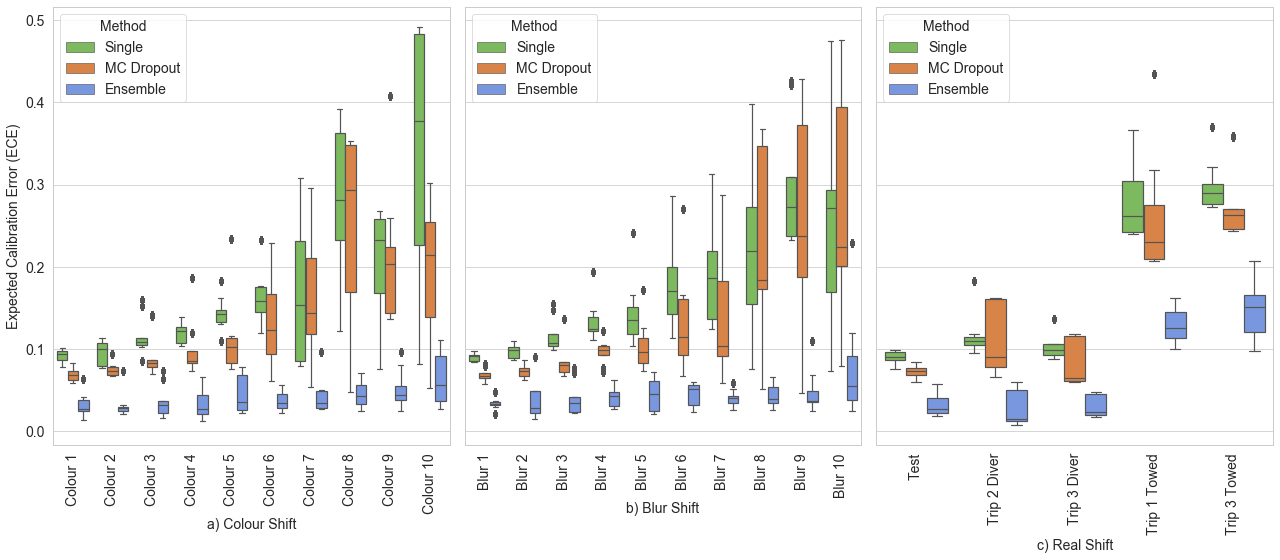

        method data_shift  ece_mean   ece_min   ece_max
0   Ensemble    Colour 1   0.032338  0.014492  0.064229
1   Ensemble    Colour 10  0.062222  0.026851  0.111138
2   Ensemble    Colour 2   0.031710  0.021601  0.073915
3   Ensemble    Colour 3   0.035956  0.016433  0.073633
4   Ensemble    Colour 4   0.033102  0.013229  0.065714
5   Ensemble    Colour 5   0.044899  0.022293  0.078040
6   Ensemble    Colour 6   0.035993  0.021935  0.056427
7   Ensemble    Colour 7   0.041875  0.027574  0.096190
8   Ensemble    Colour 8   0.044298  0.024477  0.071015
9   Ensemble    Colour 9   0.050176  0.024376  0.096000
10  MC Dropout  Colour 1   0.069010  0.058804  0.083303
11  MC Dropout  Colour 10  0.192943  0.052301  0.301758
12  MC Dropout  Colour 2   0.075136  0.067496  0.093935
13  MC Dropout  Colour 3   0.092047  0.069498  0.141460
14  MC Dropout  Colour 4   0.098626  0.073382  0.186906
15  MC Dropout  Colour 5   0.110538  0.075466  0.234006
16  MC Dropout  Colour 6   0.132858  0.061249  0

In [41]:
def expected_calibration_error(y_true, y_pred, num_bins=15):
    #print(y_true)
    #print(y_pred)
    
    pred_y = np.argmax(y_pred, axis=-1)
    correct = (pred_y == y_true).astype(np.float32)
    prob_y = np.max(y_pred, axis=-1)
    #print(correct)

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    
    # this makes it adaptive 
    b = np.quantile(prob_y, b)
    b = np.unique(b)
    num_bins = len(b)
    
    bins = np.digitize(prob_y, bins=b, right=True)

    o = 0
    for b in range(num_bins):
        mask = bins == b
        if np.any(mask):
            o += np.abs(np.sum(correct[mask] - prob_y[mask]))

    return o / y_pred.shape[0]

def plot_calibration_errors(df, i=0):
    
    ece_dict = {}
    eces = []
    briers = []
    df["ece"] = np.nan
    print("gen eces")
    
    # calculate ECE values and add them to the dataframe
    for run_name in df.run_name.unique():
        
        y_true = df[df['run_name'] == run_name]['true_index'].values
        y_true = np.asarray(list(y_true), dtype=np.float32)
        
        prediction_probs = df[df['run_name'] == run_name]['prediction_dist'].values
        prediction_probs = np.asarray(list(prediction_probs), dtype=np.float32)
        ece = expected_calibration_error(y_true, prediction_probs,15)
        
        ece_dict[run_name] = ece
        
    print("inserting eces")
    for run_name in df.run_name.unique():
        df.loc[df['run_name'] == run_name, 'ece'] = ece_dict[run_name]
    print("inserted")
    
    # add a flag to the dataframe so we can label the shift category
    df["shift_category"] = ""
    
    df.loc[(df['data_shift'].str.contains("Trip")), 'shift_category'] = "Real"
    df.loc[(df['data_shift'].str.contains("Test")), 'shift_category'] = "Real"
    
    df.loc[(df['data_shift'].str.contains("Col")), 'shift_category'] = "Colour"
    df.loc[(df['data_shift'].str.contains("Blur")), 'shift_category'] = "Blur"
    
    real = df[df['shift_category'] == "Real"]
    colour = df[df['shift_category'] == "Colour"]
    blur = df[df['shift_category'] == "Blur"]
   
 
    
    '''
    
    sns.set_palette('rainbow')
    
    '''
    # plot the boxplots in 3 cols
    sns.set_style('whitegrid')
    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))
    
    sub = sns.boxplot(x="data_shift", y="ece", hue="method", data=colour, ax=axes[0], palette=colors)
    sub.set(xlabel='a) Colour Shift', ylabel='Expected Calibration Error (ECE)')
    axes[0].tick_params(axis='x', rotation=90)
    sub.get_legend().set_title("Method")

    sub = sns.boxplot(x="data_shift", y="ece", hue="method", data=blur, ax=axes[1], palette=colors)
    sub.set(xlabel='b) Blur Shift', ylabel='')
    axes[1].tick_params(axis='x', rotation=90)
    sub.get_legend().set_title("Method")

    sub = sns.boxplot(x="data_shift", y="ece", hue="method", data=real, ax=axes[2], palette=colors)
    sub.set(xlabel='c) Real Shift', ylabel='')
    axes[2].tick_params(axis='x', rotation=90)
    sub.get_legend().set_title("Method")
    
    fig = plt.gcf()
    
    #plt.legend()
    plt.tight_layout()
    plt.show()
    #fig.savefig("ece_boxplots.eps", format="eps", dpi=1000)
    fig.savefig("ece_boxplots.pdf", format="pdf", dpi=1000)
    
    
    # calculate and print numerical values that are in the plot for the results section 
    grouped_multiple = colour.groupby(['method', 'data_shift']).agg({'ece': ['mean', 'min', 'max']})
    grouped_multiple.columns = ['ece_mean', 'ece_min', 'ece_max']
    grouped_multiple = grouped_multiple.reset_index()
    print( grouped_multiple )
    
    agg_func_describe = {'ece': ['describe']}
    grouped_multiple = colour.groupby(['method', 'data_shift']).agg(agg_func_describe).round(2)
    print(grouped_multiple)
    
    agg_func_describe = {'ece': ['describe']}
    grouped_multiple = blur.groupby(['method', 'data_shift']).agg(agg_func_describe).round(2)
    print(grouped_multiple)
    
    agg_func_describe = {'ece': ['describe']}
    grouped_multiple = real.groupby(['method', 'data_shift']).agg(agg_func_describe).round(2)
    print(grouped_multiple)
    
plot_calibration_errors(df, 1) 

# Helper functions for plot the calibration curves

In [31]:
def plot_calibration_curve_with_variance(df, ax=None):
    plot = sns.lineplot(data=df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci=100, label="", ax=ax)
    return plot

def package_and_plot_calibration_curve_withvariance(df, ax=None):
    fraction_of_positives = []
    mean_predicted_values = []
    data_shifts = []
    run_names = []
    clf_scores = []
    plot_labels = []
    ece_scores = []

    #for data_shift in df.data_shift.unique():
    for run_name in df.run_name.unique():

        prediction_dists = df[df['run_name'] == run_name]['prediction_score'].values
        prediction_dists = np.asarray(list(prediction_dists), dtype=np.float32)
        y_true_binary = df[df['run_name'] == run_name]['correct_prediction'].values
        y_true_binary = np.asarray(list(y_true_binary), dtype=np.float32)
        
        y_true = df[df['run_name'] == run_name]['true_index'].values

        y_true = np.asarray(list(y_true), dtype=np.float32)
        data_shift = df[df['run_name'] == run_name]['data_shift'].values[0]
        
        true_labels = df[df['run_name'] == run_name]['y_true'].values
        true_labels = np.asarray(list(true_labels), dtype=np.int32)
        prediction_probs = df[df['run_name'] == run_name]['prediction_dist'].values
        prediction_probs = np.asarray(list(prediction_probs), dtype=np.float32)
        
        prediction_dists = prediction_dists.astype(float)
        y_true = y_true.astype(float)

        fraction_of_positive, mean_predicted_value = calibration_curve(y_true_binary, prediction_dists, n_bins=15, strategy='quantile')
        clf_score = []
        ece = expected_calibration_error(y_true, prediction_probs,10)
        
        for index, item in enumerate(fraction_of_positive):
            fraction_of_positives.append(fraction_of_positive[index])
            mean_predicted_values.append(mean_predicted_value[index])
            data_shifts.append(data_shift)
            run_names.append(run_name)
            clf_scores.append(clf_score)
            plot_labels.append(data_shift)
            ece_scores.append(ece)
            
    mean_predicted_values = np.round(mean_predicted_values, 1)
    
    plot_df = pd.DataFrame(data={"fraction_of_positives": fraction_of_positives, 
                                 "mean_predicted_values": mean_predicted_values, 
                                 "data_shifts": data_shifts, 
                                 "run_names": run_names, 
                                 "clf_scores": clf_scores,
                                 "plot_labels": plot_labels,
                                 "ece_scores": ece_scores})  
    
    return plot_df


### Prefilter dataframes

In [32]:
bayes_df = df[df['method'].str.contains("MC Dropout")]
ensemble_df = df[df['method'].str.contains("Ensemble")]
vanilla_df = df[df['method'].str.contains("Single")]

# Plot the colour shift curves

/home/mat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


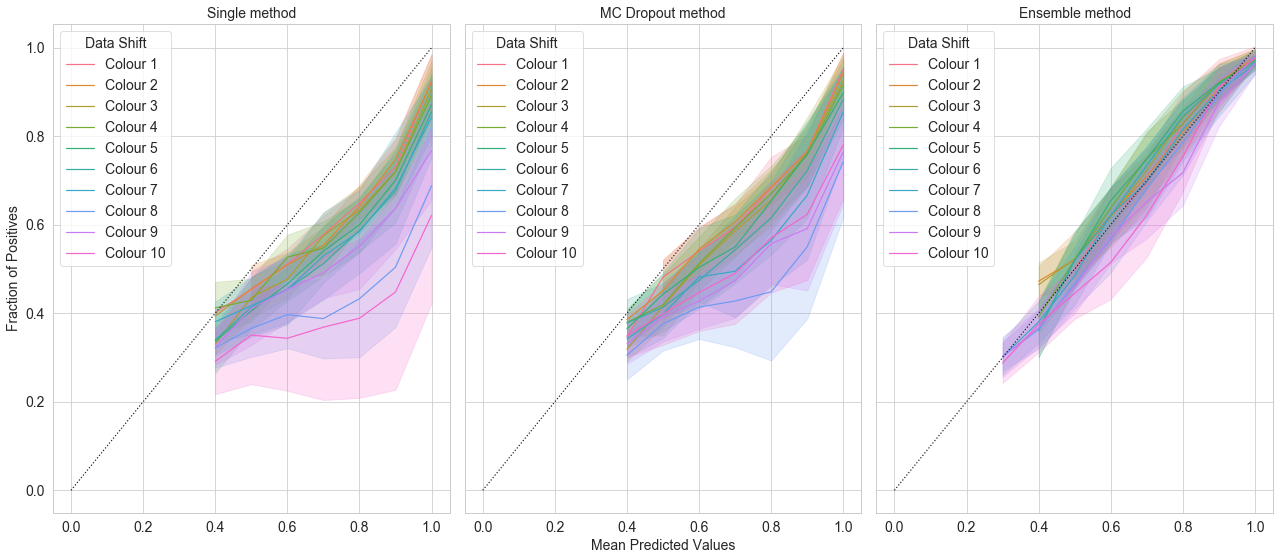

Single results
                                  fraction_of_positives          
                                                   mean       std
data_shifts mean_predicted_values                                
Colour 1    0.4                    0.401575             NaN      
            0.5                    0.453732              0.041704
            0.6                    0.510613              0.035260
            0.7                    0.577502              0.042634
            0.8                    0.649023              0.035690
            0.9                    0.730609              0.061497
            1.0                    0.925844              0.060487
Colour 10   0.4                    0.291339              0.074343
            0.5                    0.350628              0.110862
            0.6                    0.343470              0.118658
            0.7                    0.368617              0.164662
            0.8                    0.388736              0.17

In [37]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

'''
bayes_df_trip = bayes_df[bayes_df['data_shift'].str.contains("Trip")]
bayes_df_test = bayes_df[bayes_df['data_shift'].str.contains("Test")]
bayes_df_test = bayes_df_test.append(bayes_df_trip)
b_plot_df = package_and_plot_calibration_curve_withvariance(bayes_df_test)

ensemble_df_trip = ensemble_df[ensemble_df['data_shift'].str.contains("Trip")]
ensemble_df_test = ensemble_df[ensemble_df['data_shift'].str.contains("Test")]
ensemble_df_test = ensemble_df_test.append(ensemble_df_trip)
e_plot_df = package_and_plot_calibration_curve_withvariance(ensemble_df_test)

vanilla_df_trip = vanilla_df[vanilla_df['data_shift'].str.contains("Trip")]
vanilla_df_test = vanilla_df[vanilla_df['data_shift'].str.contains("Test")]
vanilla_df_test = vanilla_df_test.append(vanilla_df_trip)
v_plot_df = package_and_plot_calibration_curve_withvariance(vanilla_df_test)
'''


bayes_df_col = bayes_df[bayes_df['data_shift'].str.contains("Colour")]
b_plot_df = package_and_plot_calibration_curve_withvariance(bayes_df_col)

ensemble_df_col = ensemble_df[ensemble_df['data_shift'].str.contains("Colour")]
e_plot_df = package_and_plot_calibration_curve_withvariance(ensemble_df_col)

vanilla_df_col = vanilla_df[vanilla_df['data_shift'].str.contains("Colour")]
v_plot_df = package_and_plot_calibration_curve_withvariance(vanilla_df_col)


'''
bayes_df_col = bayes_df[bayes_df['data_shift'].str.contains("Blur")]
b_plot_df = package_and_plot_calibration_curve_withvariance(bayes_df_col)

ensemble_df_col = ensemble_df[ensemble_df['data_shift'].str.contains("Blur")]
e_plot_df = package_and_plot_calibration_curve_withvariance(ensemble_df_col)

vanilla_df_col = vanilla_df[vanilla_df['data_shift'].str.contains("Blur")]
v_plot_df = package_and_plot_calibration_curve_withvariance(vanilla_df_col)
'''

sns.set_palette('rainbow')
fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

sub = sns.lineplot(data=v_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[0])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='', ylabel='Fraction of Positives')
sub.title.set_text('Single method')
sub.get_legend().set_title("Data Shift")

sub = sns.lineplot(data=b_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[1])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='Mean Predicted Values', ylabel='Fraction of Positives')
sub.title.set_text('MC Dropout method')
sub.get_legend().set_title("Data Shift")

sub = sns.lineplot(data=e_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[2])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='', ylabel='Fraction of Positives')
sub.title.set_text('Ensemble method')
sub.get_legend().set_title("Data Shift")

fig = plt.gcf()
plt.tight_layout()
plt.show()
#fig.savefig("colour_shift_calibration.eps", format="eps", dpi=1000)
fig.savefig("colour_shift_calibration.pdf", format="pdf", dpi=1000)

# out put the value tables for the results write up 

print("Single results")
print(v_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

print("MC Dropout results")
print(b_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

print("Ensemble results")
print(e_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))


# Plot the blur shift curves

/home/mat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


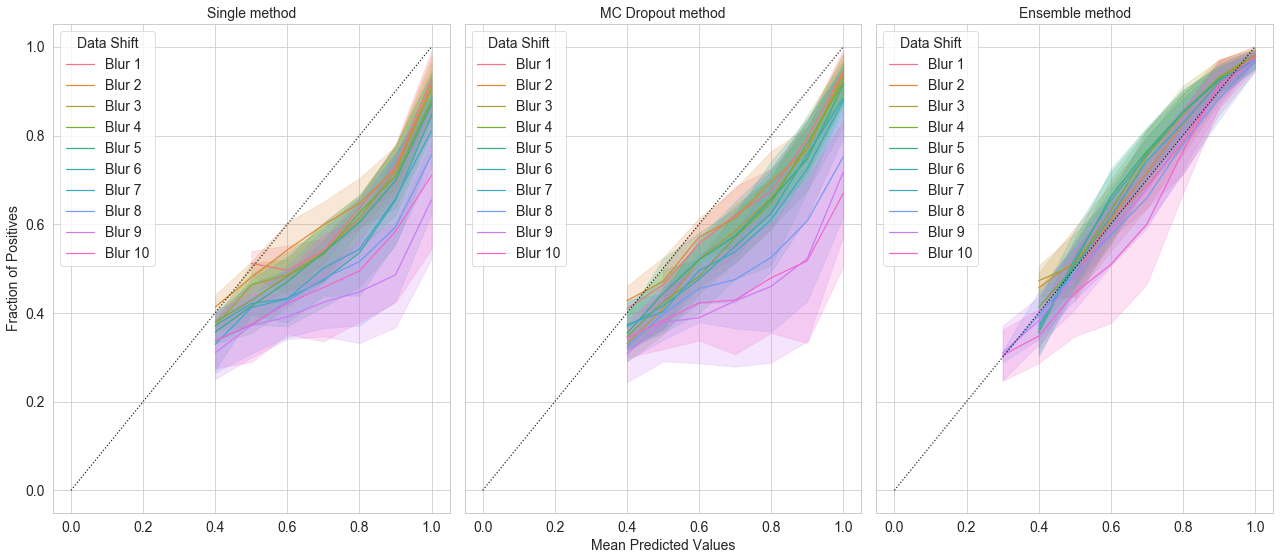

Single results
                                  fraction_of_positives          
                                                   mean       std
data_shifts mean_predicted_values                                
Blur 1      0.5                    0.511811              0.027599
            0.6                    0.496063              0.055678
            0.7                    0.540476              0.027353
            0.8                    0.637302              0.021508
            0.9                    0.730146              0.050382
            1.0                    0.928370              0.063732
Blur 10     0.4                    0.336833              0.061470
            0.5                    0.374189              0.085249
            0.6                    0.421947              0.070069
            0.7                    0.457424              0.121628
            0.8                    0.494566              0.114426
            0.9                    0.584114              0.16

In [38]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

'''
bayes_df_trip = bayes_df[bayes_df['data_shift'].str.contains("Trip")]
bayes_df_test = bayes_df[bayes_df['data_shift'].str.contains("Test")]
bayes_df_test = bayes_df_test.append(bayes_df_trip)
b_plot_df = package_and_plot_calibration_curve_withvariance(bayes_df_test)

ensemble_df_trip = ensemble_df[ensemble_df['data_shift'].str.contains("Trip")]
ensemble_df_test = ensemble_df[ensemble_df['data_shift'].str.contains("Test")]
ensemble_df_test = ensemble_df_test.append(ensemble_df_trip)
e_plot_df = package_and_plot_calibration_curve_withvariance(ensemble_df_test)

vanilla_df_trip = vanilla_df[vanilla_df['data_shift'].str.contains("Trip")]
vanilla_df_test = vanilla_df[vanilla_df['data_shift'].str.contains("Test")]
vanilla_df_test = vanilla_df_test.append(vanilla_df_trip)
v_plot_df = package_and_plot_calibration_curve_withvariance(vanilla_df_test)
'''

bayes_df_col = bayes_df[bayes_df['data_shift'].str.contains("Blur")]
b_plot_df = package_and_plot_calibration_curve_withvariance(bayes_df_col)

ensemble_df_col = ensemble_df[ensemble_df['data_shift'].str.contains("Blur")]
e_plot_df = package_and_plot_calibration_curve_withvariance(ensemble_df_col)

vanilla_df_col = vanilla_df[vanilla_df['data_shift'].str.contains("Blur")]
v_plot_df = package_and_plot_calibration_curve_withvariance(vanilla_df_col)

sns.set_palette('rainbow')
fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

sub = sns.lineplot(data=v_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[0])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='', ylabel='Fraction of Positives')
sub.title.set_text('Single method')
sub.get_legend().set_title("Data Shift")

sub = sns.lineplot(data=b_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[1])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='Mean Predicted Values', ylabel='Fraction of Positives')
sub.title.set_text('MC Dropout method')
sub.get_legend().set_title("Data Shift")

sub = sns.lineplot(data=e_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[2])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='', ylabel='Fraction of Positives')
sub.title.set_text('Ensemble method')
sub.get_legend().set_title("Data Shift")

fig = plt.gcf()
plt.tight_layout()
plt.show()
#fig.savefig("blur_shift_calibration.eps", format="eps", dpi=1000)
fig.savefig("blur_shift_calibration.pdf", format="pdf", dpi=1000)

# out put the value tables for the results write up 

print("Single results")
print(v_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

print("MC Dropout results")
print(b_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

print("Ensemble results")
print(e_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

# Plot the real shift curves

/home/mat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


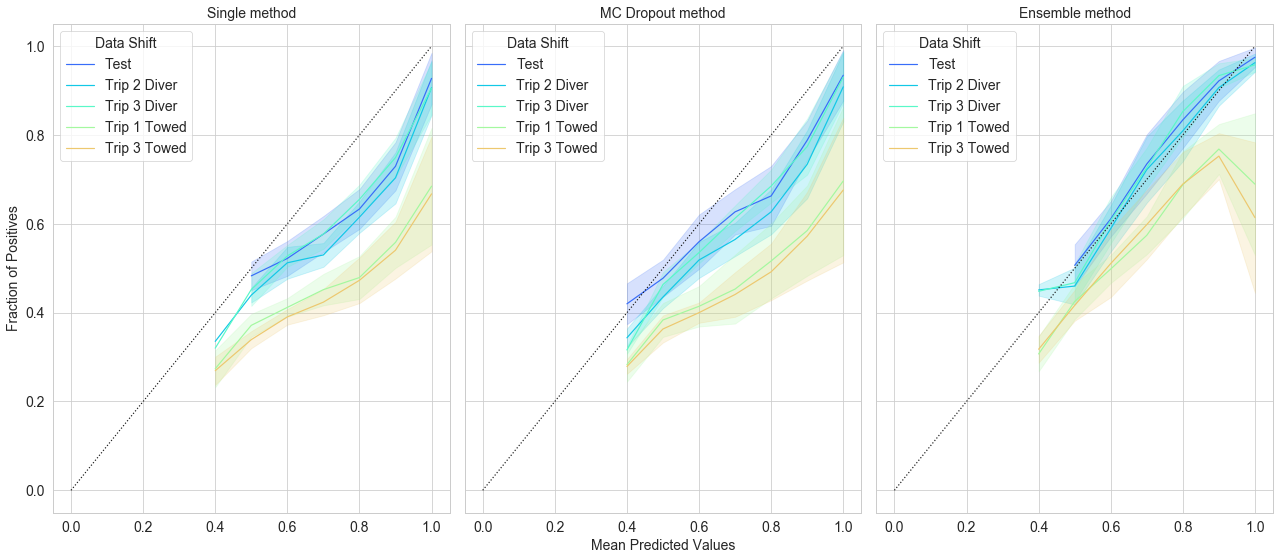

Single results
                                   fraction_of_positives          
                                                    mean       std
data_shifts  mean_predicted_values                                
Test         0.5                    0.482940              0.032146
             0.6                    0.522135              0.039226
             0.7                    0.576984              0.040650
             0.8                    0.633469              0.044942
             0.9                    0.729703              0.054189
             1.0                    0.927645              0.057822
Trip 1 Towed 0.4                    0.273763              0.041463
             0.5                    0.371490              0.025688
             0.6                    0.411937              0.020807
             0.7                    0.451879              0.035406
             0.8                    0.479131              0.048271
             0.9                    0.558357   

In [39]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


bayes_df_trip = bayes_df[bayes_df['data_shift'].str.contains("Trip")]
bayes_df_test = bayes_df[bayes_df['data_shift'].str.contains("Test")]
bayes_df_test = bayes_df_test.append(bayes_df_trip)
b_plot_df = package_and_plot_calibration_curve_withvariance(bayes_df_test)

ensemble_df_trip = ensemble_df[ensemble_df['data_shift'].str.contains("Trip")]
ensemble_df_test = ensemble_df[ensemble_df['data_shift'].str.contains("Test")]
ensemble_df_test = ensemble_df_test.append(ensemble_df_trip)
e_plot_df = package_and_plot_calibration_curve_withvariance(ensemble_df_test)

vanilla_df_trip = vanilla_df[vanilla_df['data_shift'].str.contains("Trip")]
vanilla_df_test = vanilla_df[vanilla_df['data_shift'].str.contains("Test")]
vanilla_df_test = vanilla_df_test.append(vanilla_df_trip)
v_plot_df = package_and_plot_calibration_curve_withvariance(vanilla_df_test)


sns.set_palette('rainbow')
fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

sub = sns.lineplot(data=v_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[0])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='', ylabel='Fraction of Positives')
sub.title.set_text('Single method')
sub.get_legend().set_title("Data Shift")

sub = sns.lineplot(data=b_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[1])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='Mean Predicted Values', ylabel='Fraction of Positives')
sub.title.set_text('MC Dropout method')
sub.get_legend().set_title("Data Shift")

sub = sns.lineplot(data=e_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[2])
sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
sub.set(xlabel='', ylabel='Fraction of Positives')
sub.title.set_text('Ensemble method')
sub.get_legend().set_title("Data Shift")

fig = plt.gcf()
plt.tight_layout()
plt.show()
#fig.savefig("real_shift_calibration.eps", format="eps", dpi=1000)
fig.savefig("real_shift_calibration.pdf", format="pdf", dpi=1000)

# out put the value tables for the results write up 

print("Single results")
print(v_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

print("MC Dropout results")
print(b_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

print("Ensemble results")
print(e_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

# Plot the F1 scores 

/home/mat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

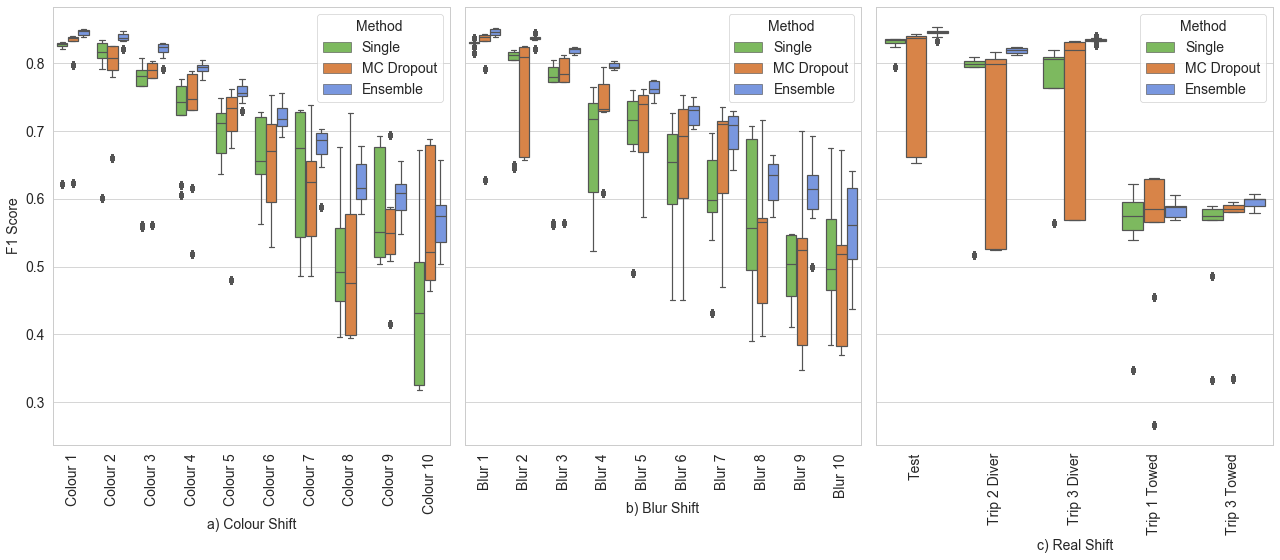

In [40]:
def calculate_f1_scores(df):
    f1s = []
    f1_dict = {}
    for run_name in df.run_name.unique():
        prediction_indexes = df[df['run_name'] == run_name]['prediction_index'].values
        true_indexes = df[df['run_name'] == run_name]['true_index'].values

        prediction_indexes = prediction_indexes.astype(int)
        true_indexes = true_indexes.astype(int) 
        
        f1 = recall_score(true_indexes, prediction_indexes, average='weighted')
        f1_dict[run_name] = f1
        #f1s = f1s + ( [f1] * len(true_indexes) ) 
    
    
    df["f1_score"] = np.nan
    for run_name in df.run_name.unique():
        df.loc[df['run_name'] == run_name, 'f1_score'] = f1_dict[run_name]
    

ensemble_df["prediction_score"] = pd.to_numeric(ensemble_df["prediction_score"])
bayes_df["prediction_score"] = pd.to_numeric(bayes_df["prediction_score"])
vanilla_df["prediction_score"] = pd.to_numeric(vanilla_df["prediction_score"])

calculate_f1_scores(bayes_df)
calculate_f1_scores(ensemble_df)
calculate_f1_scores(vanilla_df)

plot_df = vanilla_df.append(bayes_df)
plot_df = plot_df.append(ensemble_df)

plot_df["shift_category"] = ""
    

plot_df.loc[(plot_df['data_shift'].str.contains("Trip")), 'shift_category'] = "Real"
plot_df.loc[(plot_df['data_shift'].str.contains("Test")), 'shift_category'] = "Real"

plot_df.loc[(plot_df['data_shift'].str.contains("Col")), 'shift_category'] = "Colour"
plot_df.loc[(plot_df['data_shift'].str.contains("Blur")), 'shift_category'] = "Blur"

real = plot_df[plot_df['shift_category'] == "Real"]
colour = plot_df[plot_df['shift_category'] == "Colour"]
blur = plot_df[plot_df['shift_category'] == "Blur"]

colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

sub = sns.boxplot(x="data_shift", y="f1_score", hue="method", data=colour, ax=axes[0], palette=colors)
sub.set(xlabel='a) Colour Shift', ylabel='F1 Score')
axes[0].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

sub = sns.boxplot(x="data_shift", y="f1_score", hue="method", data=blur, ax=axes[1], palette=colors)
sub.set(xlabel='b) Blur Shift', ylabel='')
axes[1].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

sub = sns.boxplot(x="data_shift", y="f1_score", hue="method", data=real, ax=axes[2], palette=colors)
sub.set(xlabel='c) Real Shift', ylabel='')
axes[2].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

fig = plt.gcf()
plt.tight_layout()
plt.show()
#fig.savefig("f1_boxplots.png", dpi=1000)
#fig.savefig("f1_boxplots.eps", format="eps", dpi=1000)
fig.savefig("f1_boxplots.pdf", format="pdf", dpi=1000)